# Error fields
This notebook illustrates the error field computation using different techniques, including the so-called *Clever Poor Man's Error* (CPME) method.

In [1]:
using divand
using PyPlot

### Reading data
Download the file (it not already done) and read it.

In [3]:
varname = "Salinity"
filename = "WOD-Salinity-Provencal.nc"

if !isfile(filename)    
    download("https://b2drop.eudat.eu/s/UsF3RyU3xB1UM2o/download",filename)
end

In [2]:
value,lon,lat,depth,obstime,ids = loadobs(Float64,filename,"Salinity");

### Topography and grid definition
See other notebooks for explanation. Here just code replicated to get topography defining the mask.

Define domain and resolution, create the domain.

See other notebooks for explanation. Here just code replicated to get topography defining the mask.

In [5]:
dx = dy = 0.125/2.
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6

mask,(pm,pn),(xi,yi) = divand_rectdom(lonr,latr);

Download the bathymetry file from B2drop if necessary and load it.

In [6]:
bathname = "gebco_30sec_4.nc"
if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/ACcxUEZZi6a4ziR/download",bathname)
else
    info("Bathymetry file already downloaded")
end

bx,by,b = load_bath(bathname,true,lonr,latr);

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  222M  100  222M    0     0  15.3M      0  0:00:14  0:00:14 --:--:-- 17.3M


(2.5:0.0625:12.0, 42.3:0.0625:44.55, [-713.328 -1058.46 … -457.094 -559.781; -698.68 -970.352 … -520.617 -504.406; … ; -199.547 -150.794 … -3.0918 -1.60937; -206.094 -178.191 … -3.1875 -1.03125])

Create a land-sea mask based on the bathymetry.

In [9]:
mask = falses(size(b,1),size(b,2))

for j = 1:size(b,2)
    for i = 1:size(b,1)
        mask[i,j] = b[i,j] >=1.0
    end
end

### Data selection for example

Cross validation, error calculations etc. assume independant data. Hence do not take high-resolution vertical profiles with all data but restrict yourself to specific small depth range. Here we limit outselves to August data at surface:

Cross validation, error calculations etc. assume independant data. Hence do not take high-resolution vertical profiles with all data but restrict yourself to specific small depth range. Here August data at surface:

In [10]:
sel = (depth .< 1) .& (Dates.month.(obstime) .== 8)

value = value[sel]
lon = lon[sel]
lat = lat[sel]
depth = depth[sel]
obstime = obstime[sel]
ids = ids[sel];
@show (size(value))
checkobs((lon,lat,depth,obstime),value,ids)

size(value) = (1956,)
              minimum and maximum of obs. dimension 1: (3.0763332843780518, 11.779999732971191)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (0.0, 0.9921539425849915)
              minimum and maximum of obs. dimension 4: (1910-08-09T00:00:00, 2014-08-28T19:36:00)
                          minimum and maximum of data: (24.886999130249023, 39.18000030517578)


### Analysis
Analysis parameters have been calibrated in the other notebook example. 

**WARNING:** if the statistical parameters are incorrectly estimated, the error fields are meaningless and only provide an idea of data coverage.

The analysis parameters are:

In [12]:
len=0.3
epsilon2=1;

Analysis `fi` using mean data as background.    
Structure `s` is stored for later use in error calculation

In [14]:
fi,s = divandrun(mask,(pm,pn),(xi,yi),(lon,lat),value-mean(value),len,epsilon2);

Create a simple plot of the analysis

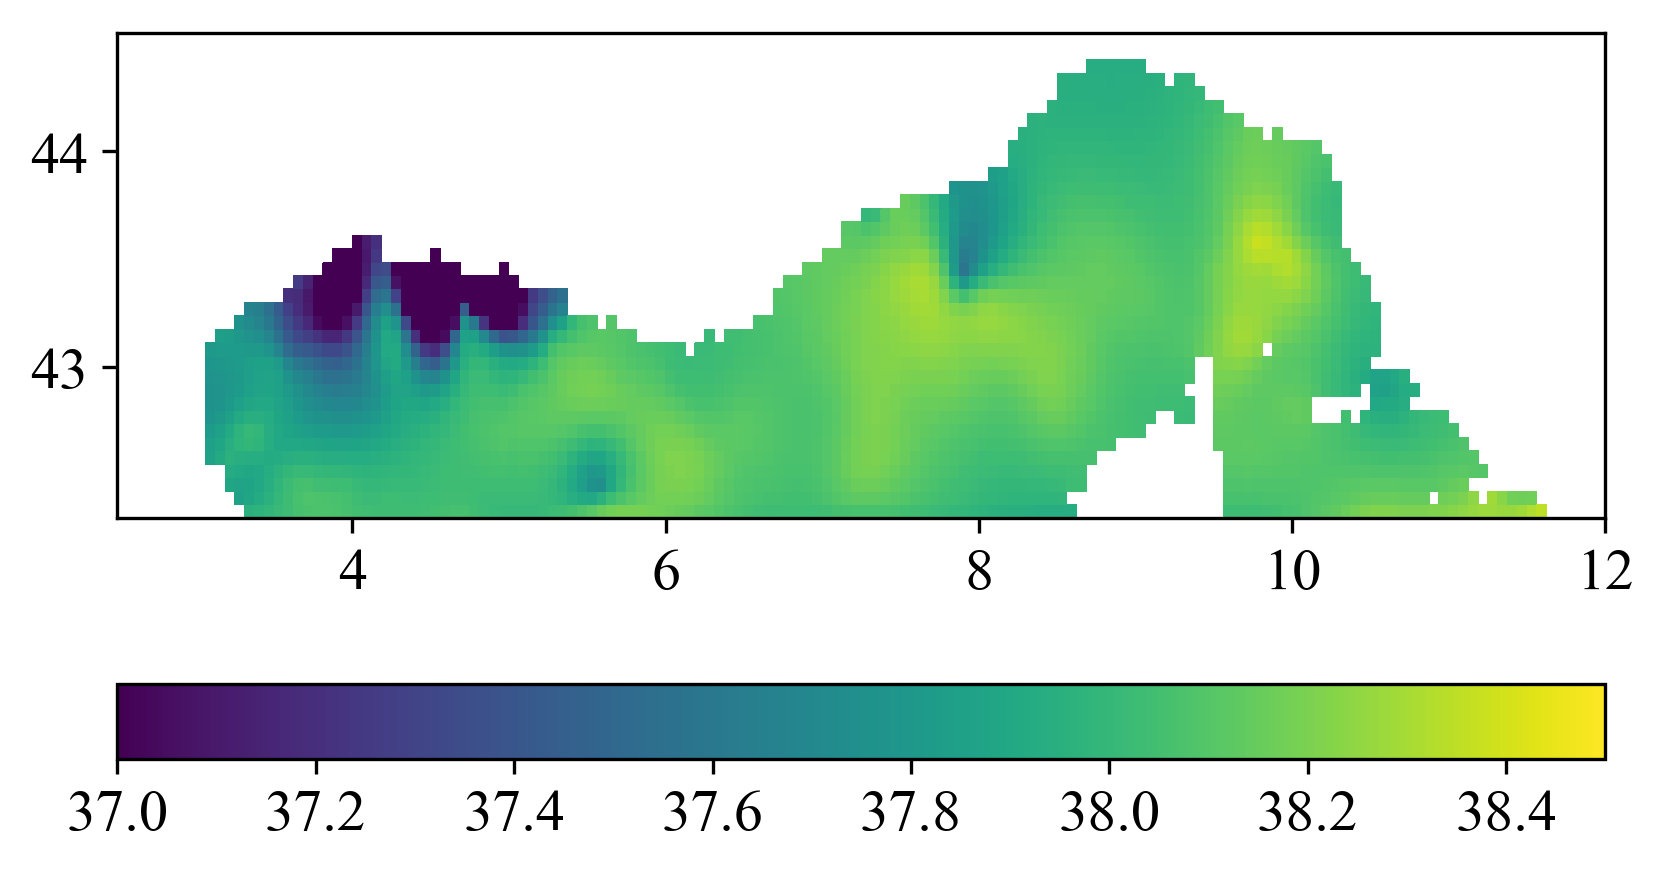

In [15]:
pcolor(xi,yi,fi+mean(value),vmin=37,vmax=38.5);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

## Exact error and approximations

Details can be found in:

Approximate and Efficient Methods to Assess Error Fields in Spatial Gridding with Data Interpolating Variational Analysis (DIVA) Beckers, Jean-Marie; Barth, Alexander;  Troupin, Charles, Alvera-Azcarate, A.  *Journal of Atmospheric & Oceanic Technology* (2014), **31(2)**, 515-530     
https://orbi.uliege.be/handle/2268/161069      
https://journals.ametsoc.org/doi/abs/10.1175/JTECH-D-13-00130.1

In the 2D case you can try to calculate the exact error expression. This demands the computationally expensive evaluation of diag(s.P) accessible via the analysis returned structure `s`. Only available with `divandrun`.

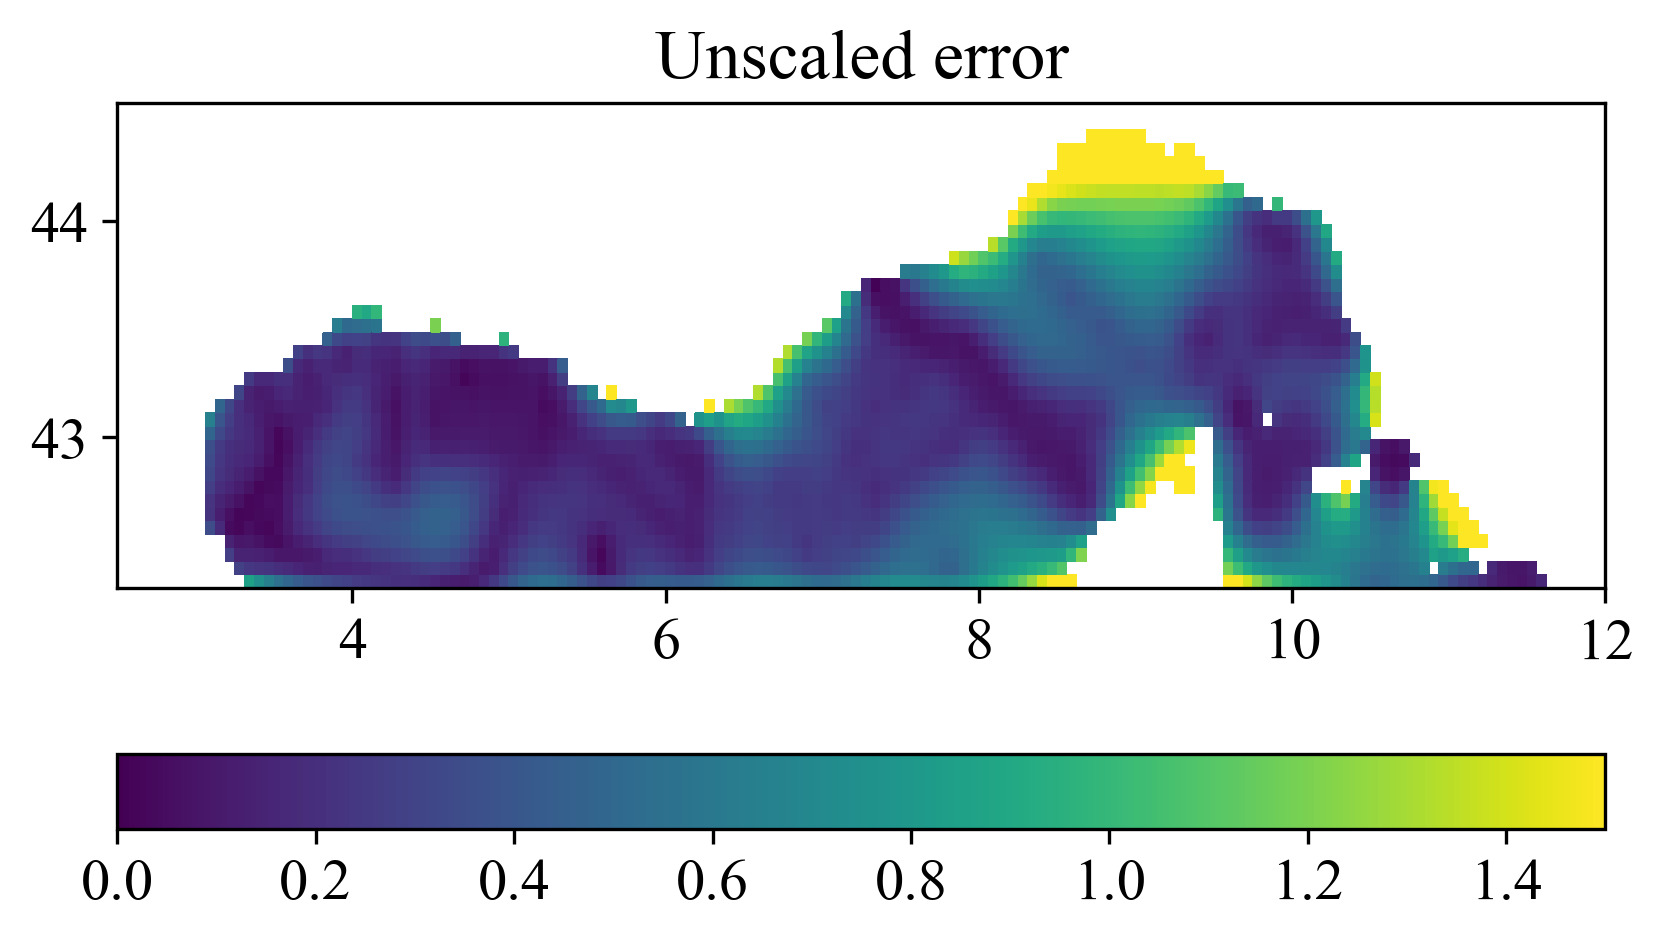

In [16]:
exerr,= statevector_unpack(s.sv,diag(s.P))
exerr[find(x -> x == false,mask)]=NaN

pcolor(xi,yi,exerr,vmin=0, vmax=1.5);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Unscaled error");

Relative error by scaling with background variance Berr estimated using data with high errors

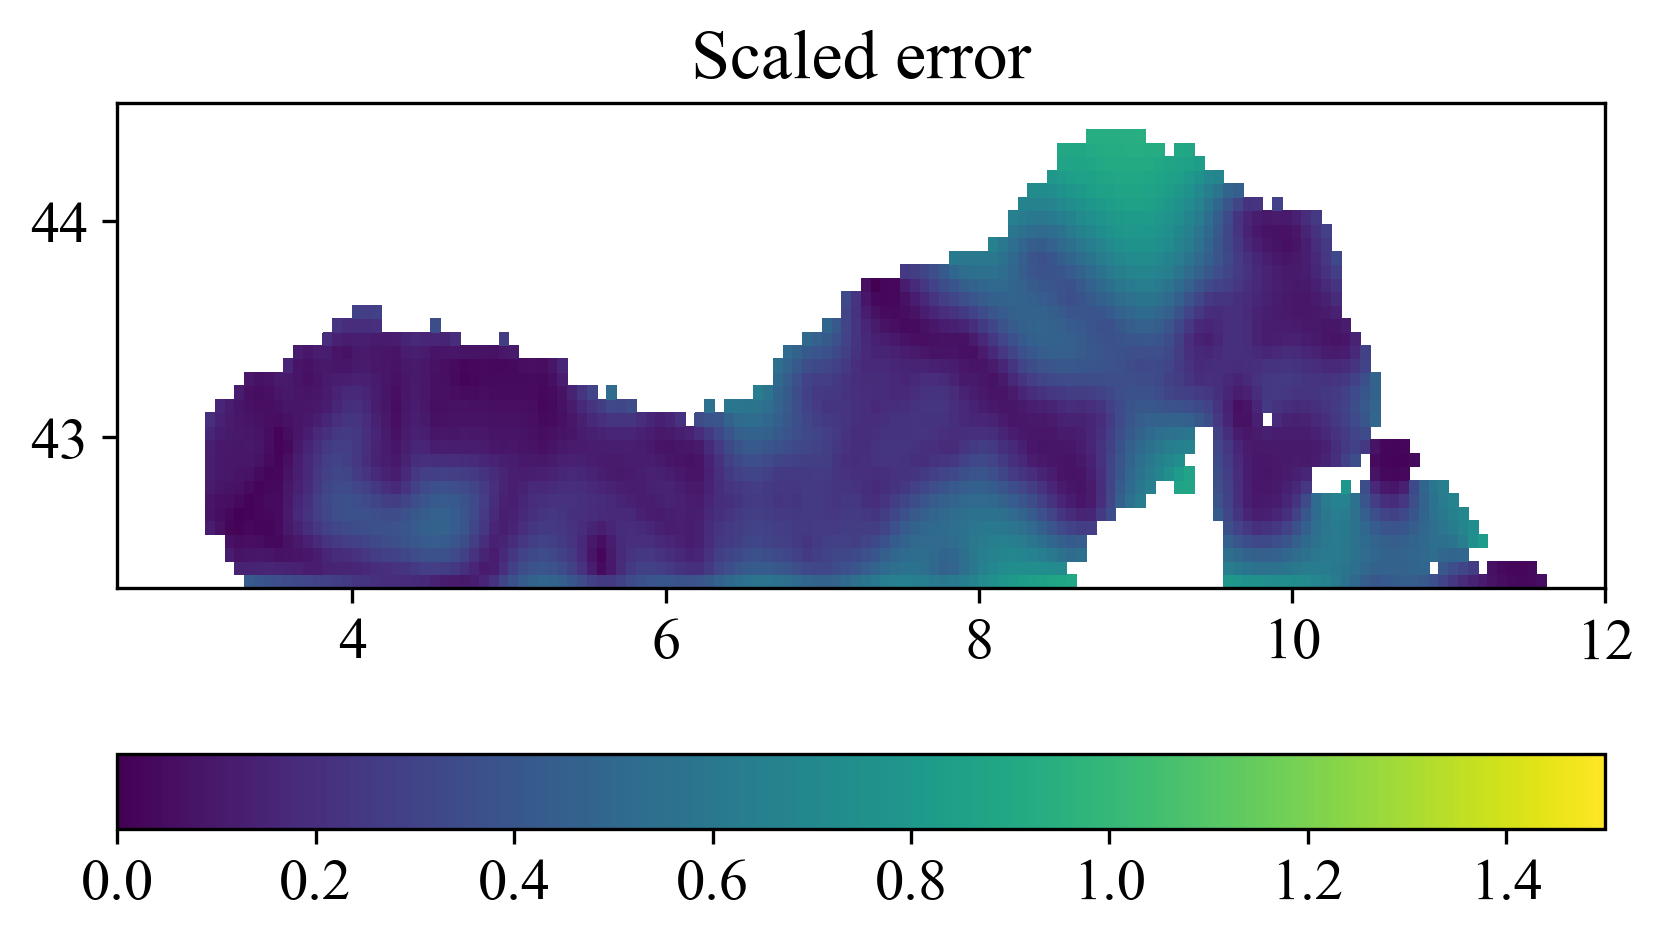

In [17]:
epsilon2huge=1E6
fib,sb = divandrun(mask,(pm,pn),(xi,yi),(lon,lat),value,len,epsilon2huge);
Berr,= statevector_unpack(sb.sv,diag(sb.P))

pcolor(xi,yi,exerr./Berr,vmin=0, vmax=1.5);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Scaled error");

Now clever poor man's error. Useage as for divandrun

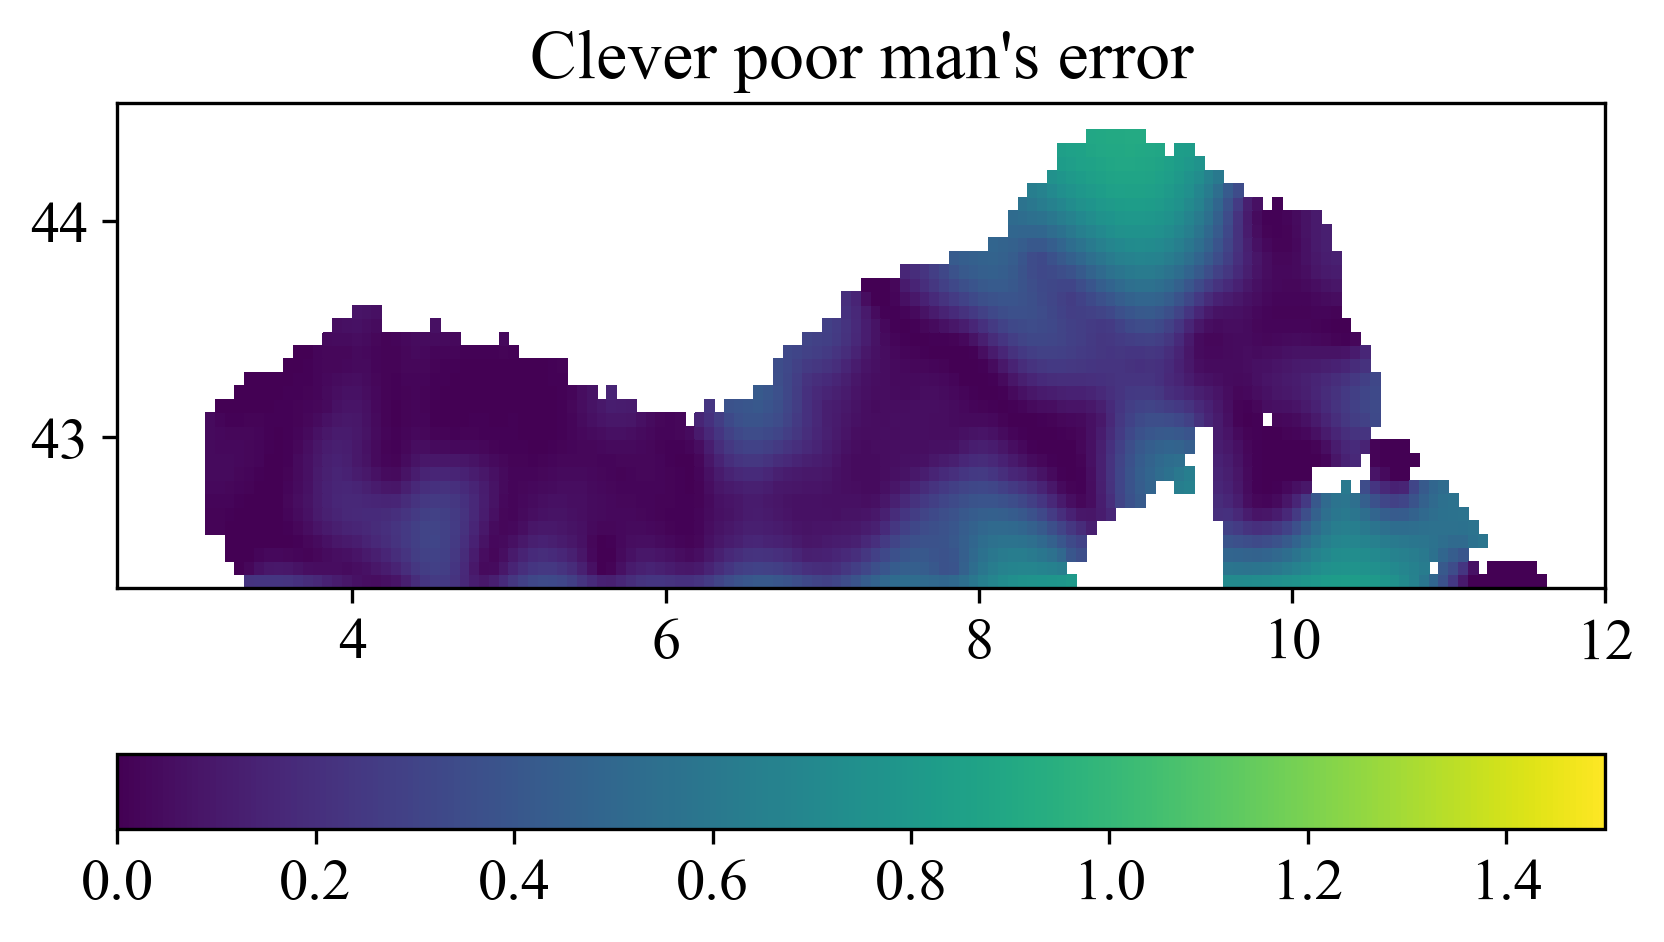

In [19]:
cpme = divand_cpme(mask,(pm,pn),(xi,yi),(lon,lat),value,len,epsilon2)

pcolor(xi,yi,cpme,vmin=0, vmax=1.5);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Clever poor man's error");


Do you see any difference between the exact and clever poor man's error ? 
## Difference between error fields
We also overlayed the data positions.

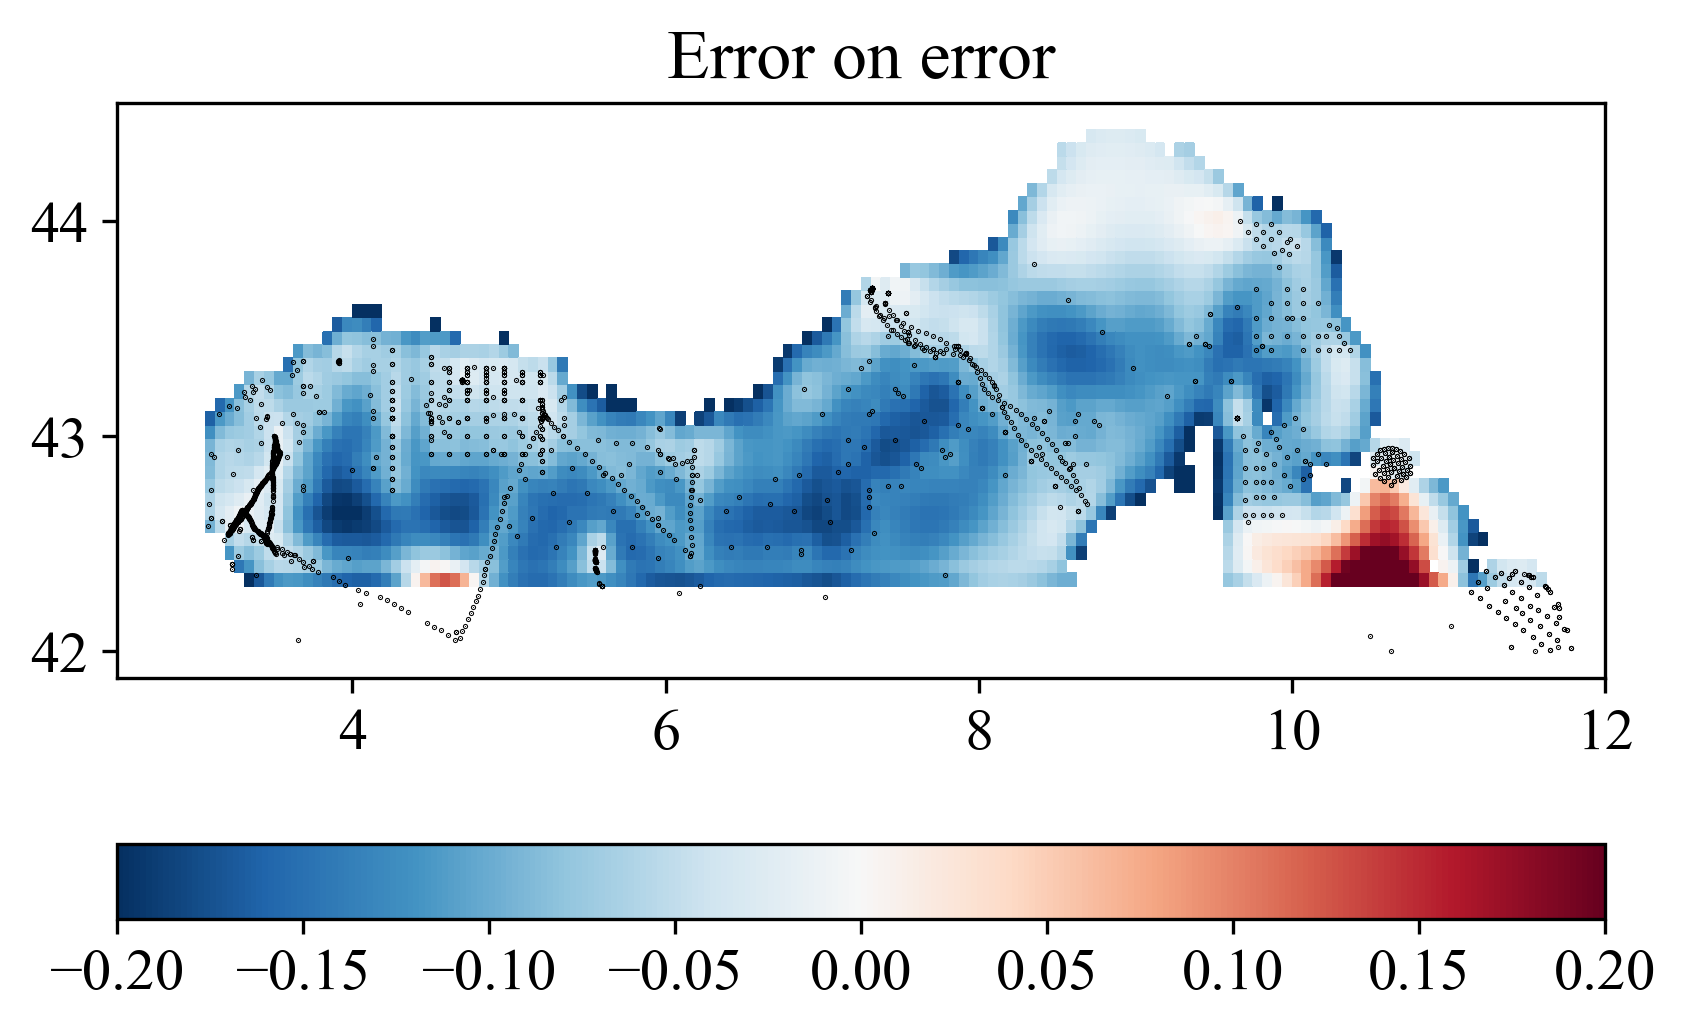

In [32]:
pcolor(xi,yi,cpme-exerr./Berr,vmin=-0.2, vmax=0.2, cmap="RdBu_r");
colorbar(orientation="horizontal")
plot(lon, lat, "k.", markersize=.5)
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Error on error");

Another approximation to the error field: AEXERR

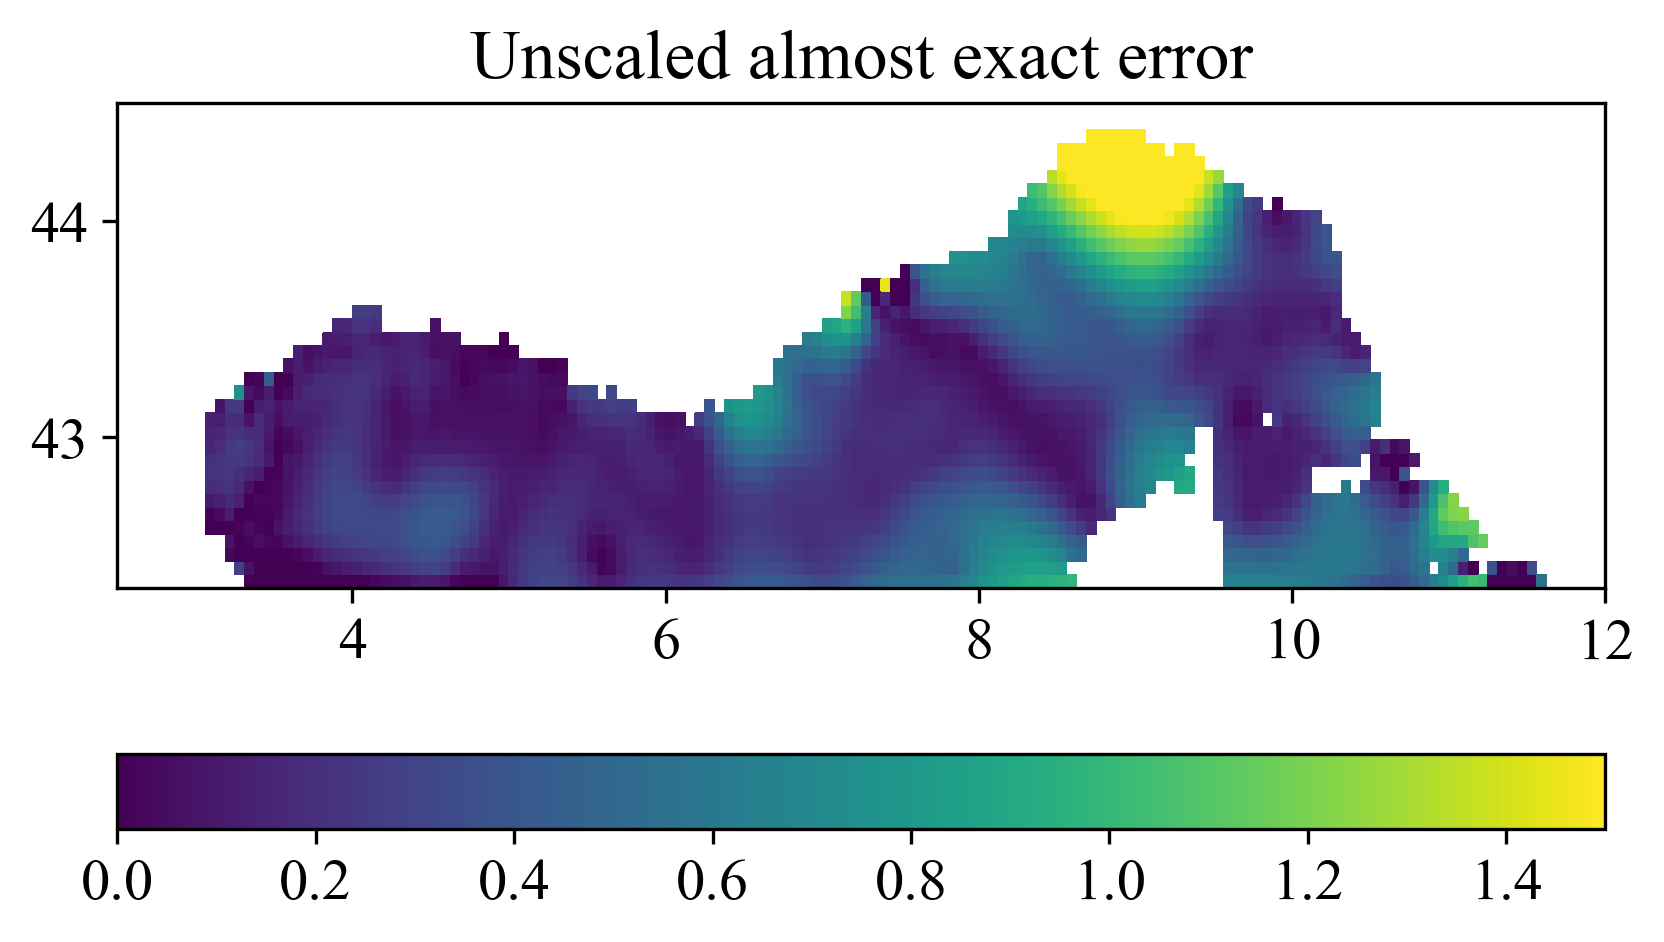

PyObject Text(0.5,1,'Unscaled almost exact error')

In [35]:
myerr,bjmb,fa,sa = divand_aexerr(mask,(pm,pn),(xi,yi),(lon,lat),value,len,epsilon2)
if myerr==0
    error("No need to approximate error, use direct calculation")
else
    pcolor(xi,yi,myerr,vmin=0, vmax=1.5);
    colorbar(orientation="horizontal")
    gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
    title("Unscaled almost exact error");
end

Scaled AXERR error

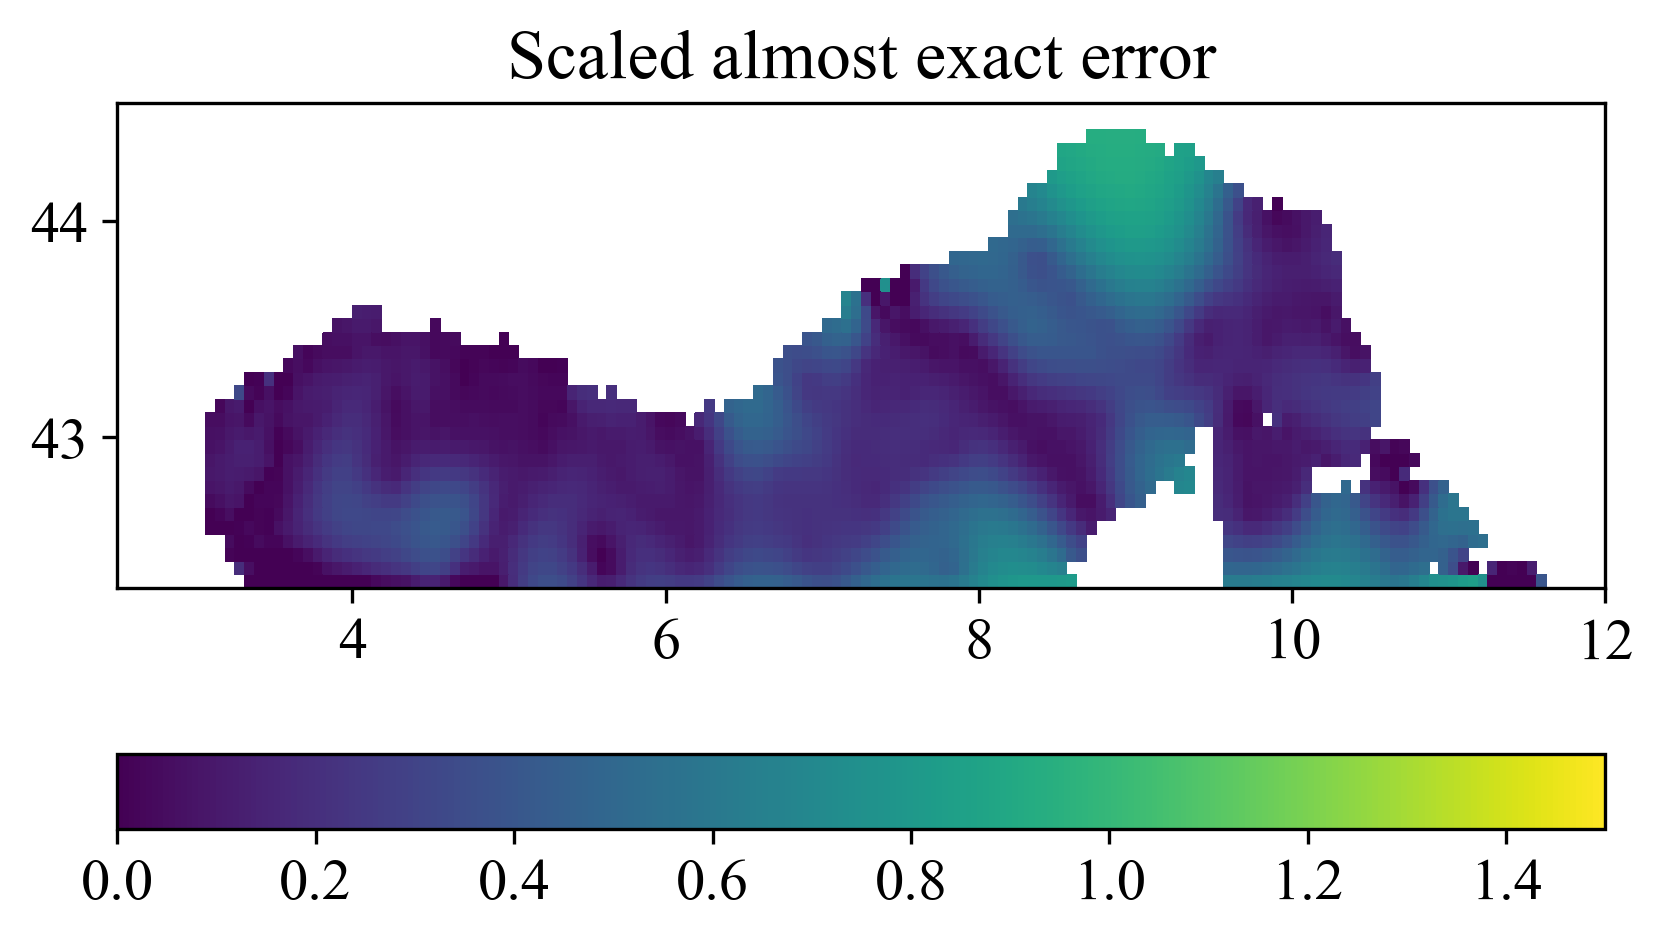

PyObject Text(0.5,1,'Scaled almost exact error')

In [36]:
if myerr==0
    error("No need to approximate error, use direct calculation")
else
    pcolor(xi,yi,myerr./bjmb,vmin=0, vmax=1.5);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
    title("Scaled almost exact error");
end

# Exercise 
1. Modify the (L, $\epsilon^2$) parameters.
2. Re-run the analysis.
3. See how the error field behaves.

# Conclusion
In view of the uncertainties on statistical parameters (L, $\epsilon^2$), the *clever poor man's error* is generally a sufficient approximation for the error fields. This is the one implemented in the divandgo high-level analysis function. 